In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
dig = pd.read_csv("../data/Dig-MNIST.csv")
sample = pd.read_csv("../data/sample_submission.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


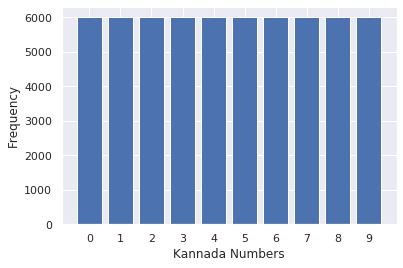

In [5]:
y = train.label.value_counts()
x = y.index
plt.bar(x,y)
plt.xticks(x, labels=x)
plt.xlabel('Kannada Numbers')
plt.ylabel('Frequency')
plt.show()


In [6]:
print(f"Train data shape {train.shape}")
print(f"Test data shape {test.shape}")

Train data shape (60000, 785)
Test data shape (5000, 785)


In [7]:
x_train = train.drop(columns=['label'])  #largest pixel value
y_train = to_categorical(train.label) #one-hot 
x_test = test.drop(columns="id")


In [8]:
x_train[train.label == 0].iloc[0].to_numpy().astype(np.uint8).reshape(28, 28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         21, 234, 255, 255, 149,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

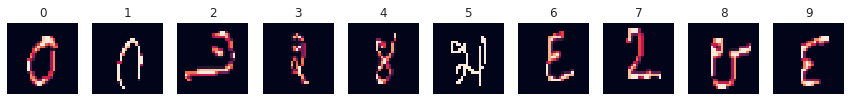

In [9]:
fig, ax = plt.subplots(ncols=10, figsize=(15,15))
for i in range(10):
    kannada = x_train[train.label == i]
    ax[i].set_title(i)
    ax[i].axis('off')
    ax[i].imshow(kannada.iloc[0, :].to_numpy().astype(np.uint8).reshape(28, 28))

In [10]:
x_train = x_train /255
x_test = x_test / 255

In [11]:
x_train = x_train.values.reshape(-1,28,28,1) # 28 * 28 = 784
x_test = x_test.values.reshape(-1,28,28,1)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [13]:
# CREATE MORE TRAINING IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [14]:
datagen.fit(X_train)

In [31]:
EPOCHS=50
BATCH_SIZE=64

In [29]:
callbacks = [ReduceLROnPlateau(monitor='val_acc',
                               patience=5,
                               verbose=1,
                               factor=0.5,
                               min_lr=0.00001)]

In [27]:
#build based on :
#https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist#1.-How-many-convolution-subsambling-pairs?
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu')) 
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [103]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)       

In [30]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS,
#                               batch_size=BATCH_SIZE,
                              validation_data = (X_test,Y_test),
                              verbose = 1,
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                              callbacks=callbacks)

Epoch 1/50
750/750 [==============================] - 15s 20ms/step - loss: 0.2951 - accuracy: 0.9076 - val_loss: 0.0385 - val_accuracy: 0.9898
Epoch 2/50
 10/750 [..............................] - ETA: 13s - loss: 0.1069 - accuracy: 0.9672

/home/mars/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


750/750 [==============================] - 14s 18ms/step - loss: 0.0774 - accuracy: 0.9753 - val_loss: 0.0545 - val_accuracy: 0.9838
Epoch 3/50
750/750 [==============================] - 14s 19ms/step - loss: 0.0597 - accuracy: 0.9821 - val_loss: 0.0203 - val_accuracy: 0.9939
Epoch 4/50
750/750 [==============================] - 14s 18ms/step - loss: 0.0518 - accuracy: 0.9840 - val_loss: 0.0236 - val_accuracy: 0.9936
Epoch 5/50
750/750 [==============================] - 14s 19ms/step - loss: 0.0463 - accuracy: 0.9861 - val_loss: 0.0236 - val_accuracy: 0.9939
Epoch 6/50
750/750 [==============================] - 14s 19ms/step - loss: 0.0416 - accuracy: 0.9872 - val_loss: 0.0297 - val_accuracy: 0.9921
Epoch 7/50
750/750 [==============================] - 14s 19ms/step - loss: 0.0394 - accuracy: 0.9883 - val_loss: 0.0356 - val_accuracy: 0.9898
Epoch 8/50
750/750 [==============================] - 14s 19ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0267 - val_accuracy: 0.9917
Epo

In [102]:
model.save_weights("../data/kannada-cnn.h5")

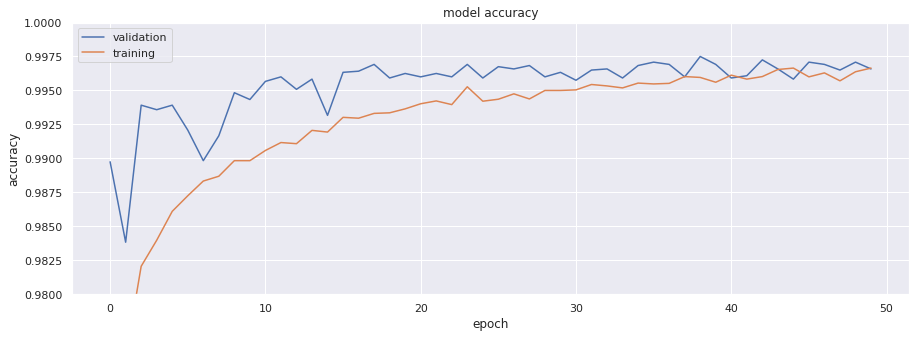

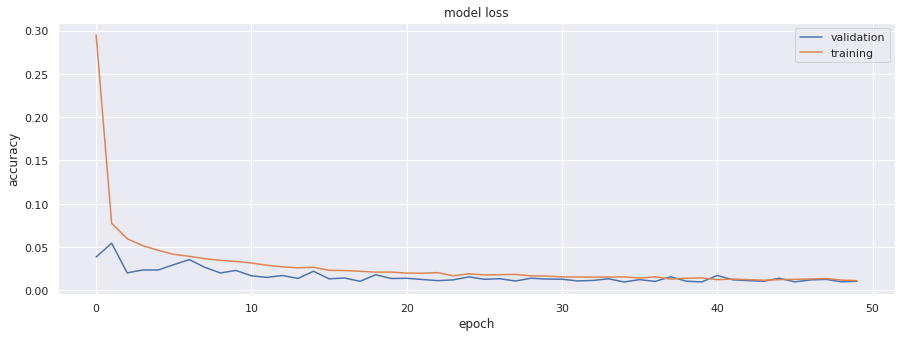

In [32]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.plot(history.history['accuracy'], label = 'training')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
axes = plt.gca()
axes.set_ylim([0.98,1])

plt.figure(figsize=(15,5))
plt.plot(history.history['val_loss'], label = 'validation')
plt.plot(history.history['loss'], label = 'training')
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [44]:
%%time
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
target = np.argmax(Y_test,axis=1)

CPU times: user 1.22 s, sys: 96.2 ms, total: 1.31 s
Wall time: 1.08 s


In [60]:
cm = confusion_matrix(target, pred)
print(cm)

[[1168    9    0    0    0    0    0    0    0    0]
 [   1 1217    0    0    0    0    0    0    0    0]
 [   1    0 1223    0    0    0    0    0    0    0]
 [   1    0    0 1177    1    0    0    5    0    0]
 [   0    1    0    0 1218    1    0    0    0    1]
 [   0    0    0    1    0 1187    0    0    0    0]
 [   0    0    0    0    0    0 1167    2    0    0]
 [   0    0    0    4    0    0    3 1212    0    0]
 [   0    0    0    0    0    0    0    0 1186    0]
 [   0    0    0    0    0    0   10    0    0 1204]]


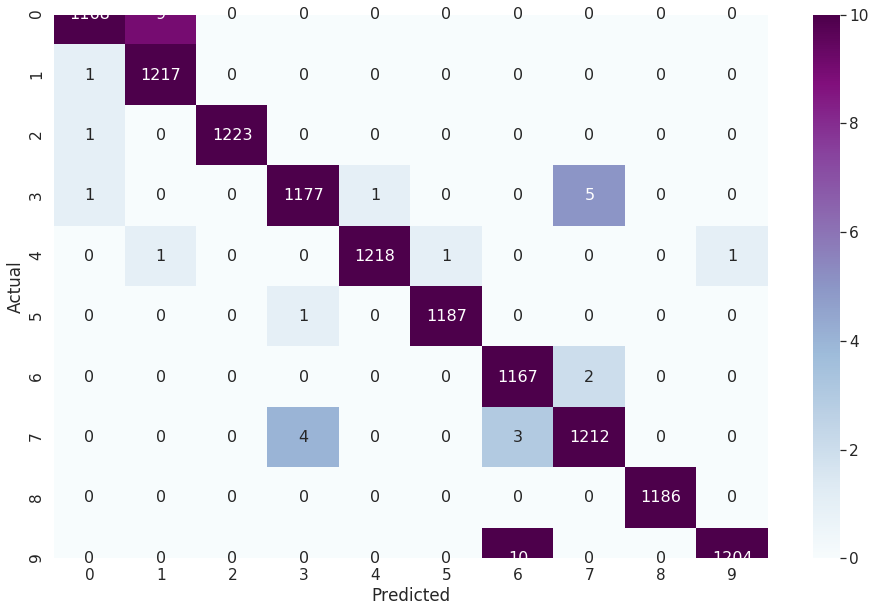

In [80]:
#source: https://www.kaggle.com/agungor2/various-confusion-matrix-plots 

df_cm = pd.DataFrame(cm, columns=np.unique(target), index = np.unique(target))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (16,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="BuPu", annot=True, fmt='g',annot_kws={"size": 16}, vmax=10)# font size
plt.show()

In [76]:
accuracy_score(target, pred)

0.9965833333333334

In [79]:
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1177
           1       0.99      1.00      1.00      1218
           2       1.00      1.00      1.00      1224
           3       1.00      0.99      0.99      1184
           4       1.00      1.00      1.00      1221
           5       1.00      1.00      1.00      1188
           6       0.99      1.00      0.99      1169
           7       0.99      0.99      0.99      1219
           8       1.00      1.00      1.00      1186
           9       1.00      0.99      1.00      1214

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



In [82]:
submission_pred = model.predict(x_test)

In [84]:
submission_pred.shape

(5000, 10)

In [86]:
submission_pred = np.argmax(submission_pred, axis=1)

In [97]:
df_submission = pd.DataFrame({'id': np.arange(0,submission_pred.shape[0]),
                             'label':submission_pred})

In [99]:
df_submission.head(10)

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
5,5,7
6,6,1
7,7,9
8,8,3
9,9,4


In [101]:
df_submission.to_csv('../data/submission.csv',index=False)